In [ ]:
# Tesseract OCR 설치
!apt-get update
!apt-get install -y tesseract-ocr

# Python용 pytesseract 라이브러리 설치
!pip install pytesseract
!pip install opencv-python-headless

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,188 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,626 kB]
Get:13 https://r2u.stat.illinois.edu/u

In [ ]:
!apt-get install -y tesseract-ocr-kor

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tesseract-ocr-kor
0 upgraded, 1 newly installed, 0 to remove and 51 not upgraded.
Need to get 1,052 kB of archives.
After this operation, 1,693 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-kor all 1:4.00~git30-7274cfa-1.1 [1,052 kB]
Fetched 1,052 kB in 1s (873 kB/s)
Selecting previously unselected package tesseract-ocr-kor.
(Reading database ... 123679 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-kor_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-kor (1:4.00~git30-7274cfa-1.1) ...
Setting up tesseract-ocr-kor (1:4.00~git30-7274cfa-1.1) ...


In [ ]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

In [ ]:
from google.colab import files
uploaded = files.upload()

uploaded_image_path = list(uploaded.keys())[0]
print(f"Uploaded file: {uploaded_image_path}")

Saving KakaoTalk_20241007_145504111_03.jpg to KakaoTalk_20241007_145504111_03.jpg
Uploaded file: KakaoTalk_20241007_145504111_03.jpg


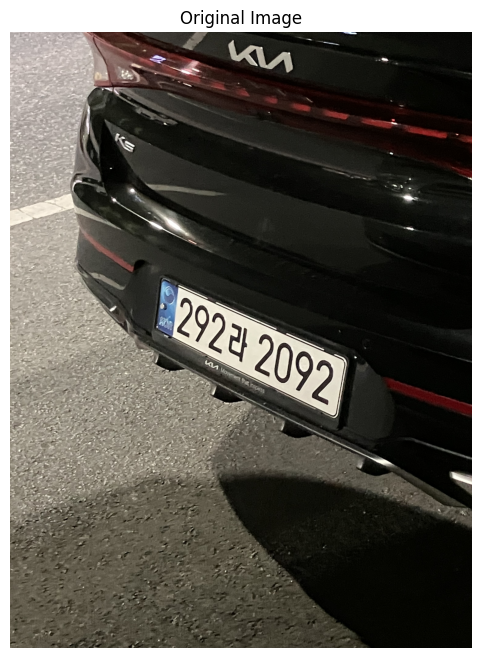

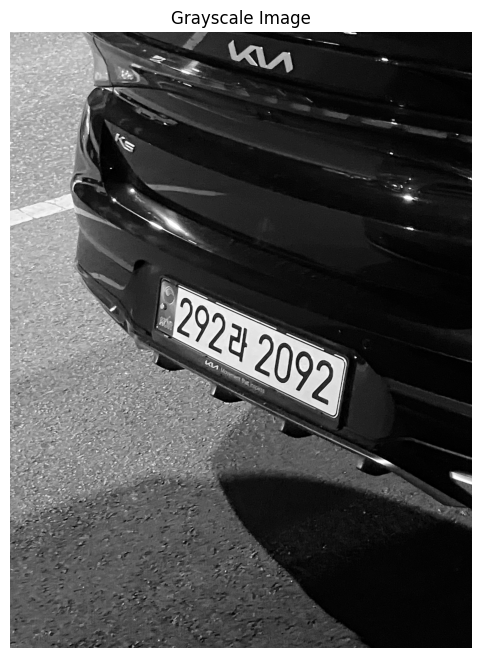

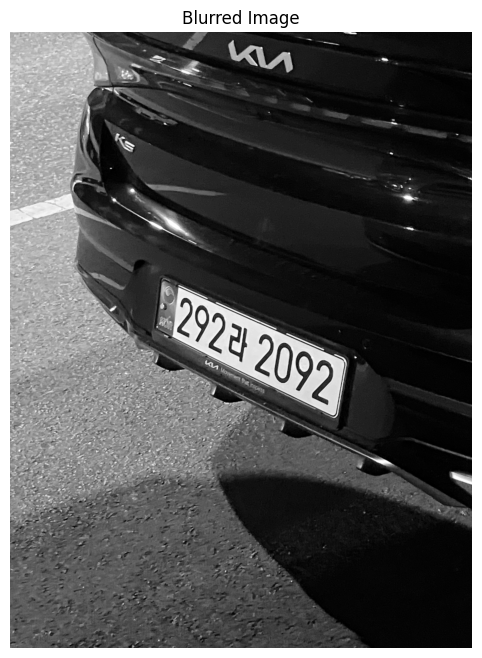

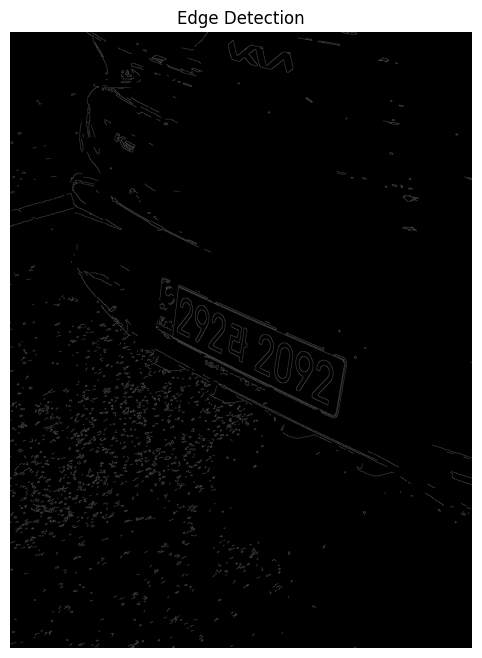

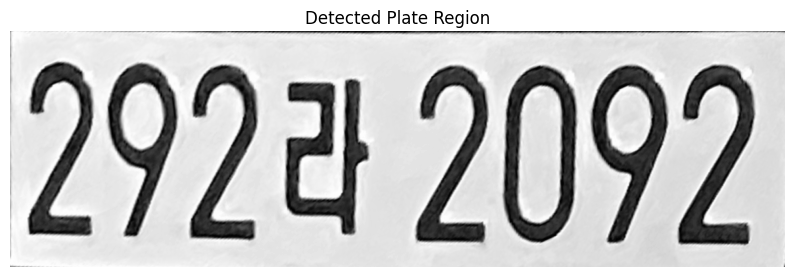

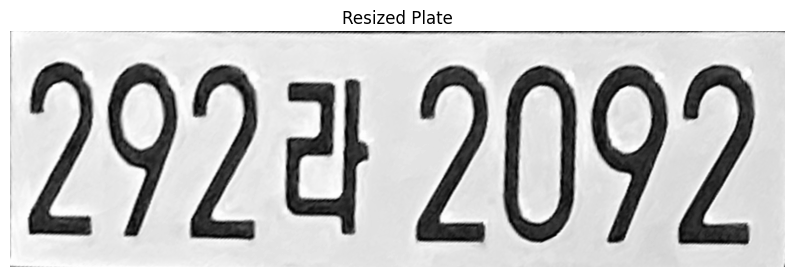

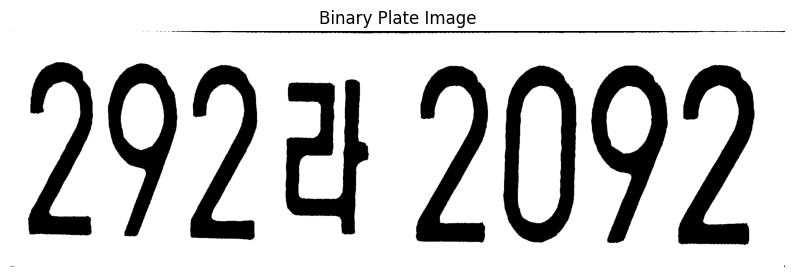

In [ ]:
import cv2
import pytesseract
import numpy as np
from matplotlib import pyplot as plt

pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

def show_image(title, image):
    """이미지 출력 함수"""
    plt.figure(figsize=(10, 8))
    cmap = 'gray' if len(image.shape) == 2 else None
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

def extract_license_plate(image_path):
    image = cv2.imread(image_path)

    # 원본 이미지 출력
    show_image("Original Image", cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # 전처리: 그레이스케일 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    show_image("Grayscale Image", gray)

    # 전처리: 블러링 및 엣지 검출
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    show_image("Blurred Image", blur)

    edged = cv2.Canny(blur, 100, 200)
    show_image("Edge Detection", edged)

    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    plate = None
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)

        if len(approx) == 4:
            pts = approx.reshape(4, 2)

            rect = np.zeros((4, 2), dtype="float32")
            s = pts.sum(axis=1)
            rect[0] = pts[np.argmin(s)]
            rect[2] = pts[np.argmax(s)]

            diff = np.diff(pts, axis=1)
            rect[1] = pts[np.argmin(diff)]
            rect[3] = pts[np.argmax(diff)]

            (tl, tr, br, bl) = rect
            widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
            widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
            maxWidth = max(int(widthA), int(widthB))

            heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
            heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
            maxHeight = max(int(heightA), int(heightB))

            dst = np.array([
                [0, 0],
                [maxWidth - 1, 0],
                [maxWidth - 1, maxHeight - 1],
                [0, maxHeight - 1]
            ], dtype="float32")

            M = cv2.getPerspectiveTransform(rect, dst)
            plate = cv2.warpPerspective(gray, M, (maxWidth, maxHeight))
            show_image("Detected Plate Region", plate)
            break

    if plate is not None:
        plate = cv2.resize(plate, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
        show_image("Resized Plate", plate)

        _, plate_binary = cv2.threshold(plate, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        show_image("Binary Plate Image", plate_binary)

        text = pytesseract.image_to_string(plate_binary, lang='kor+eng', config='--psm 6 preserve_interword_spaces')

        return text.strip()
    else:
        return "No plate detected"

image_path = uploaded_image_path  # 입력 이미지 경로 설정
extracted_text = extract_license_plate(image_path)